# Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import json
import math
import types
from datetime import datetime
import csv
from dateutil.parser import parse

## Creating the docs to work from

In [2]:
#appending the csvs I created in the initial gathering together
playlists1 = pd.read_csv('../data/raw/playlists.csv')
playlists2 = pd.read_csv('../data/raw/playlists2.csv')
playlists3 = pd.read_csv('../data/raw/playlists3.csv')

playlists_read = playlists1.append(playlists2)
playlists_read = playlists_read.append(playlists3)

In [3]:
playlists_read.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556 entries, 0 to 647
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2556 non-null   int64 
 1   description  2348 non-null   object
 2   spotify_id   2556 non-null   object
 3   name         2553 non-null   object
 4   no_tracks    2556 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 119.8+ KB


In [4]:
playlists_read.head(10)

,Unnamed: 0,description,spotify_id,name,no_tracks
0,0,Justin Bieber is on top of the Hottest 50!,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,50
1,1,"Music from Lil Durk, Playboi Carti and Kid Cudi.",37i9dQZF1DX0XUsuxWHRQd,RapCaviar,50
2,2,The newest music from Foo Fighters along with ...,37i9dQZF1DXcF6B6QPhFDv,Rock This,50
3,3,The world's biggest dance hits. Music from Ima...,37i9dQZF1DX4dyzvuaRJ0n,mint,79
4,4,"Today's top country hits of the week, worldwid...",37i9dQZF1DX1lVhptIYRda,Hot Country,53
5,5,"Today's top Latin hits are right here, on ¡Viv...",37i9dQZF1DX10zKzsJ2jva,¡Viva Latino!,50
6,6,The pulse of R&B music today. Cover: PARTYNEX...,37i9dQZF1DX4SBhb3fqCJd,Are & Be,36
7,7,Your daily update of the most played tracks in...,37i9dQZEVXbLRQDuF5jeBp,United States Top 50,50
8,8,Your daily update of the most played tracks ri...,37i9dQZEVXbMDoHDwVN2tF,Global Top 50,50
9,9,Your daily update of the most viral tracks in ...,37i9dQZEVXbLiRSasKsNU9,Global Viral 50,50


In [5]:
# deduplicate the list on the spotify id -- again losing data at this point isn't a huge deal
# as this is about getting a variety of playlists for analysis, but none are required to make
# the tool better

dedup_playlists = playlists_read.drop_duplicates(subset='spotify_id')

In [6]:
# checking the dedup worked
dedup_playlists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186 entries, 0 to 647
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2186 non-null   int64 
 1   description  1979 non-null   object
 2   spotify_id   2186 non-null   object
 3   name         2183 non-null   object
 4   no_tracks    2186 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 102.5+ KB


In [20]:
# creating a test batch to work with before running the api
from random import seed
from random import sample
# seed random number generator
seed(466)
# prepare a sequence
sequence = [i for i in range(2186)]
# select a subset without replacement
subset = sample(sequence, 50)

x = 0
test_total = []
while x < len(subset):
    list = [dedup_playlists.iloc[subset[x],0], 
            dedup_playlists.iloc[subset[x],1], 
            dedup_playlists.iloc[subset[x],2],
            dedup_playlists.iloc[subset[x],3],
            dedup_playlists.iloc[subset[x],4]
           ]
    test_total.append(list)
    x += 1

print(test_total)
test_df = pd.DataFrame(test_total)
test_df.head()

[[227, "Recent tracks from the Hot Country playlist that are still smokin'.  Cover: Maren Morris", '37i9dQZF1DX6rVyqO2FaN8', 'Still Hot', 52], [555, 'Focus-enhancing piano for your study session.', '37i9dQZF1DX8NTLI2TtZa6', 'Intense Studying', 217], [1494, 'Low-key feeling ourselves while listening to these songs.', '37i9dQZF1DX3Ei2cOBgIym', 'Insecure Official Playlist', 328], [952, 'A brand new morning show from Spotify. Get your day started with news, music, and entertainment.', '37i9dQZF1EJ6c2LjkY3g5E', 'The Get Up', 35], [695, 'Kick back to the best new and recent chill tunes.', '37i9dQZF1DX4WYpdgoIcn6', 'Chill Hits', 130], [601, 'All the <a href="spotify:genre:edm_dance">big ones</a> with Surf Mesa', '37i9dQZF1DX0BcQWzuB7ZO', 'Dance Hits', 86], [1133, 'The ultimate classical playlist for yoga, meditation and daily mindfulness.', '37i9dQZF1DX4QrK4j7ie9B', 'Classical Yoga', 65], [532, 'The biggest hits in the USA! With WITHOUT YOU, Whoopty, 34+35, Lemonade, positions, Mood, Dakiti, 

,0,1,2,3,4
0,227,Recent tracks from the Hot Country playlist th...,37i9dQZF1DX6rVyqO2FaN8,Still Hot,52
1,555,Focus-enhancing piano for your study session.,37i9dQZF1DX8NTLI2TtZa6,Intense Studying,217
2,1494,Low-key feeling ourselves while listening to t...,37i9dQZF1DX3Ei2cOBgIym,Insecure Official Playlist,328
3,952,A brand new morning show from Spotify. Get you...,37i9dQZF1EJ6c2LjkY3g5E,The Get Up,35
4,695,Kick back to the best new and recent chill tunes.,37i9dQZF1DX4WYpdgoIcn6,Chill Hits,130


# Spotify Work

In [8]:
# authorization for spotify
token = util.prompt_for_user_token(
        username="rosey.waters@gmail.com",
        scope="user-read-recently-played user-read-private user-top-read user-read-currently-playing",
        client_id="e7b1f1096c82471d89d1db8030b82dd9",
        client_secret="5e635c87338b4729bc9a8bd007c2cbe1",
        redirect_uri="https://www.google.it/")

spotify = spotipy.Spotify(auth=token)

In [9]:
# function that gets the track listing for songs from a playlist id, this will be useful later!

def total_track_listing(spotify_id):
    # create the url from the spotify id and the offset
    def create_url(spotify_id, offset):
        playlist = 'https://api.spotify.com/v1/playlists/' + spotify_id + '/tracks?offset=' + str(offset)
        return playlist

    # get the json information
    def get_json(playlist):
        try:
            def track_listing(self, limit=100):
                return self._get(playlist, limit=limit)

            spotify.track_listing = types.MethodType(track_listing, spotify)

            trackers = spotify.track_listing(limit=100)

            data = json.dumps(trackers, sort_keys=True, indent=2)

            data_parse = json.loads(data)

            return data_parse
        except:
            return ""
    
    def get_tracks(json):
        # create an empty list to add the information into
        created_list = []
        data = json["items"]
        for i in data:
        
            try:
                track_name = i["track"]["name"]
                primary_artist = i["track"]["artists"][0]["name"]
                artist_list = []
                for artist in i["track"]["artists"]:
                    artist_list.append(artist["name"])
                track_id = i["track"]["id"]
                info = [track_name, primary_artist, artist_list, track_id]
                created_list.append(info)
            except: 
                pass
            
        return created_list
    # this part cycles through the tracks if there are more than 100
    final = []
    offsetter = 0
    try:
        total = get_json(create_url(spotify_id,0))['total']

        while offsetter < total:
            run = get_json(create_url(spotify_id,offsetter))
            created = get_tracks(run)
            final += created
            offsetter += 100

        return final
    except:
        return 'playlist does not exist'

In [21]:
# runs the API calls and tells you when they've been done
player = 0
total_list = []
while player < len(test_df):
    playlisting = total_track_listing(test_df.iloc[player,2])
    total_list.append(playlisting)
    player += 1
    print(str(player) + ' done')

1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done


In [22]:
# joins together the data into one dataframe for easier manipulation
total = pd.DataFrame(total_list[1])
counting = 2
while counting < len(total_list):
    try:
        total = total.append(pd.DataFrame(total_list[counting]))
    except:
        pass
    counting += 1

total.head()

,0,1,2,3
0,Calm Skies,Edu Lahmar,[Edu Lahmar],2IpHdNslMW4mijoiTKF3j3
1,Paintings,Esperanza,[Esperanza],5ddcsw3fJkGjW67wjjtpu6
2,Sleepy Meadows,Julia Andersson,[Julia Andersson],6ZolaAx9dpXGBDlD83TGAT
3,How You're Remembered,Nino Carl,[Nino Carl],2NHgyCHFDydecMMa57BcWP
4,Sweet Redolence,Cedric Armfeldt,[Cedric Armfeldt],0BXq9t3wTA8HMqFPvGxZYf


### Data Cleaning

In [23]:
# I'm going to start by looking at the tracks individually for clarity and then return to the playlists later
# right now it's about connecting the track to the genius page

# Adjusting the dataframe etc
total = total.rename(columns={0:'track_name',1:'primary_artist',2:'artists',3:'id'})
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3966 entries, 0 to 412
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   track_name      3966 non-null   object
 1   primary_artist  3966 non-null   object
 2   artists         3966 non-null   object
 3   id              3966 non-null   object
dtypes: object(4)
memory usage: 154.9+ KB


In [13]:
# imports
import requests
from bs4 import BeautifulSoup
import csv
import re
from unidecode import unidecode

In [24]:
# test if the links are viable
def genius_search(track_name, primary_artist, spotify_id, additional=''):

#artist processing
    
    # then adjusts non-latin characters
    # removes the spaces and turns them into dashes
    artist = primary_artist.replace("&","and")
    artist = unidecode(artist)
    artist = artist.replace("/","-")
    artist = re.sub("[^a-zA-z0-9 -]", "", artist)
    artist = artist.replace(" ","-")
    
#track processing
    # removes some of common features
    # then spaces and dashes
    track = track_name.replace("&","and")
    track = unidecode(track)
    track = track.replace("/","-")
    track = re.sub("[^a-zA-z0-9 -]", "", track)
    track = track.split('feat')[0]
    track = track.split('with')[0]
    track = track.strip().replace(" ","-")
    
    # creates the url
    url = "https://genius.com/" + artist + '-' + track + "-lyrics"
    
    # remove double dashes
    url = url.replace("--","-")
    singles = url.split('--')
    if len(singles) > 1:
        url = singles[0] + '-lyrics'
    
    try: 
        response = requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")

        lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
        text = lyrics[0].p.get_text()
        tester = text
        
    except:
        if len(additional) > 1:
            other = 1
            while other < len(additional):
                second = re.sub("[^a-zA-z0-9 -]", "", additional[other])
                second = second.replace(" ","-")
                new = '-and-' + second
                other += 1
            url = "https://genius.com/" + artist + '-and-' + second + '-' + track + "-lyrics"
        
            try:
                response = requests.get(url)
                html = response.text
                soup = BeautifulSoup(html, "html.parser")

                lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
                text = lyrics[0].p.get_text()
                tester = text
            except:
                try:
                    track = track_name.replace("&","and")
                    track = re.sub("[^a-zA-z0-9 -]", "", track)
                    track = track.split('feat')[0]
                    track = track.split('with')[0]
                    track = track.strip().replace(" ","-")
                    artist = primary_artist.replace("&","and")
                    artist = re.sub("[^a-zA-z0-9 -]", "", artist)
                    artist = artist.replace(" ","-")
                    url = "https://genius.com/" + artist + '-' + track + "-lyrics"
                    
                    response = requests.get(url)
                    html = response.text
                    soup = BeautifulSoup(html, "html.parser")

                    lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
                    text = lyrics[0].p.get_text()
                    tester = text
                except:
                    tester = [url, 'bad', spotify_id, artist, additional]
        else:
            tester = [url, 'bad', spotify_id, artist, additional]
    
    return tester
    

parse = 3000
parse1 = 3050
error_list = []
test = []

while parse < parse1:
    genius_tester = genius_search(total.iloc[parse,0], total.iloc[parse,1],total.iloc[parse,3],total.iloc[parse,2])
    
    if genius_tester[1] == 'bad':
        error_list.append(genius_tester)
        print(parse, ' bad')
    else:
        test.append(genius_tester)
        print(parse, ' good')
    parse += 1


3000  bad
3001  good
3002  good
3003  good
3004  good
3005  good
3006  good
3007  good
3008  good
3009  good
3010  good
3011  bad
3012  good
3013  good
3014  good
3015  good
3016  good
3017  good
3018  good
3019  good
3020  bad
3021  good
3022  good
3023  good
3024  good
3025  good
3026  bad
3027  good
3028  good
3029  good
3030  bad
3031  good
3032  good
3033  bad
3034  good
3035  good
3036  bad
3037  good
3038  good
3039  good
3040  bad
3041  good
3042  good
3043  good
3044  bad
3045  bad
3046  good
3047  good
3048  bad
3049  good


In [25]:
# just in case there's something I can still grab, but honestly, probably not
print(error_list)

[['https://genius.com/Eva-Dahlgren-Taxi-lyrics', 'bad', '5RVBrpsnxLTLqUHikdD3lv', 'Eva-Dahlgren', ['Eva Dahlgren']], ['https://genius.com/Gavin-James-Nervous-The-Ooh-Song---Mark-McCabe-Remix-lyrics', 'bad', '0L9lXMXddmoBbBUeF7A9An', 'Gavin-James', ['Gavin James', 'Mark McCabe']], ['https://genius.com/HUTS-Down-lyrics', 'bad', '6mgFmrqH0Ea48gnUHvhtzO', 'HUTS', ['HUTS', 'Jordan Jay', 'Idetto']], ['https://genius.com/Deep-Chills-Weak-lyrics', 'bad', '1Nb2v2LCq4dgZLorOGZhNJ', 'Deep-Chills', ['Deep Chills', 'Le Boeuf', 'Kersty Ryan']], ['https://genius.com/HUTS-One-Your-Name-lyrics', 'bad', '6liZV0Nrz90vVrxuNwKRI4', 'HUTS', ['HUTS', 'Jordan Jay', 'Idetto']], ['https://genius.com/HUTS-Party-Shaker-lyrics', 'bad', '4BeqeDBxUyJUmU7jRAmYRX', 'HUTS', ['HUTS', 'Jordan Jay', 'Idetto']], ['https://genius.com/HUTS-Mood-lyrics', 'bad', '5At3exVBWkAfqJGsRG8Z5L', 'HUTS', ['HUTS', 'Jordan Jay', 'Idetto']], ['https://genius.com/Jordan-Jay-hi-hey-hello-lyrics', 'bad', '7tMxQ1Vj2Hk6cw2mFKba6X', 'Jordan-Jay

In [27]:
# let's see the word cloud!
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [28]:
# removes anything between square brackets, which seems to be genius's way of
# doing things like "chorus" etc

total_lyrics = ''
for lyric in test:
    gen = re.sub("([\[]).*?([\]])", "", lyric)
    total_lyrics += gen

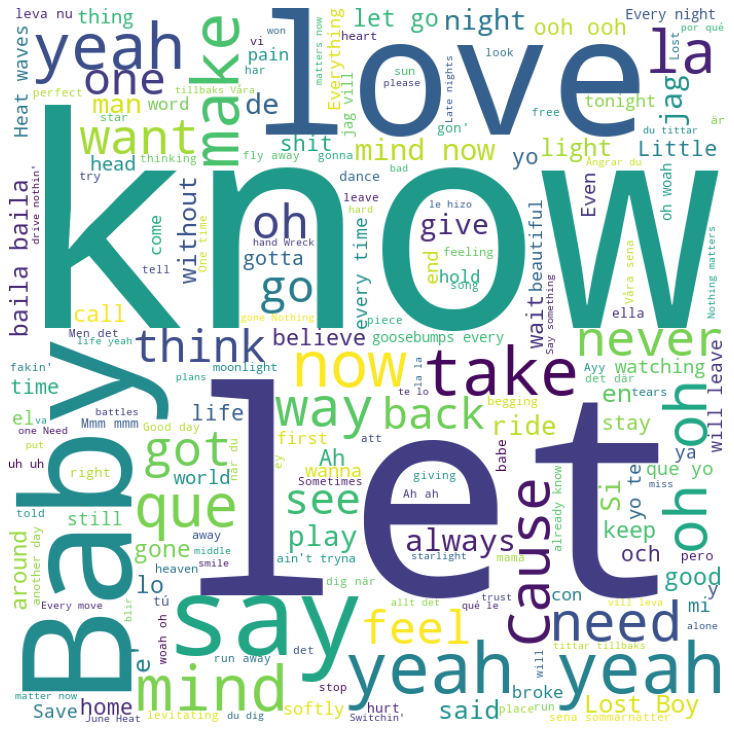

In [29]:
# build a word cloud -- just to see if there's something else that should obviously be taken out
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(total_lyrics) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()